## Aerobicity phenotype: data analysis, processing, and visualization

In [1]:
import os
import pickle
from collections import Counter

import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif
from sklearn.manifold import TSNE
from sklearn.preprocessing import MaxAbsScaler, StandardScaler
from scipy.stats import mannwhitneyu, pointbiserialr

from sklearn.preprocessing import MaxAbsScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier
import shap

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay

# 1. Read the dataset

In [2]:
input_file = '../data/all_gene_annotations.added_incompleteness_and_contamination.tsv'
y = '../data/bacdive_scrape_20230315.json.parsed.anaerobe_vs_aerobe.with_cyanos.csv'

#parametres
target_column = 'oxytolerance'
threads = 64

In [3]:
# Read GTDB
gtdb = pl.concat([
    pl.read_csv('../data/bac120_metadata_r202.tsv', separator='\t'),
    pl.read_csv('../data/ar122_metadata_r202.tsv', separator='\t')
])
gtdb = gtdb.filter(pl.col("gtdb_representative") == "t")
print("Read in {} GTDB reps".format(len(gtdb)))

gtdb = gtdb.with_columns(pl.col("gtdb_taxonomy").str.split(';').list.get(0).alias("domain"))
gtdb = gtdb.with_columns(pl.col("gtdb_taxonomy").str.split(';').list.get(1).alias("phylum"))
gtdb = gtdb.with_columns(pl.col("gtdb_taxonomy").str.split(';').list.get(2).alias("class"))
gtdb = gtdb.with_columns(pl.col("gtdb_taxonomy").str.split(';').list.get(3).alias("order"))
gtdb = gtdb.with_columns(pl.col("gtdb_taxonomy").str.split(';').list.get(4).alias("family"))
gtdb = gtdb.with_columns(pl.col("gtdb_taxonomy").str.split(';').list.get(5).alias("genus"))

Read in 47894 GTDB reps


In [4]:
# Read full data (for EDA use train+test)
d = pl.read_csv(input_file,separator='\t')#accession fpr fnr {COGs}
print("Read full data: %s", d.shape)

# Add metadata (join based on accession)
d2 = d.join(gtdb.select(['accession','domain', 'phylum','class','order','family','genus']), on="accession", how="left")#accession fpr fnr {COGs} phylum class order family
#d2 = d.join(gtdb.select(['accession', 'phylum','class','order','family','genus']), on="accession", how="left")#accession fpr fnr {COGs} phylum class order family
print("Total in d2 full data: %s", d2.shape)

Read full data: %s (147744, 2680)
Total in d2 full data: %s (147744, 2686)


In [5]:
# Read y
y0 = pl.read_csv(y, separator='\t')
y1 = y0.unique() # There are some duplicates in the cyanos, so dedup
print("Read y: %s", y1.shape)
print("Counts of each class amongst unique accessions: %s", y1.group_by(target_column).agg(pl.len()))#FIXED

Read y: %s (3161, 2)
Counts of each class amongst unique accessions: %s shape: (2, 2)
┌──────────────┬──────┐
│ oxytolerance ┆ len  │
│ ---          ┆ ---  │
│ str          ┆ u32  │
╞══════════════╪══════╡
│ anaerobe     ┆ 1055 │
│ aerobe       ┆ 2106 │
└──────────────┴──────┘


In [6]:
d3 = d2.join(y1, on="accession", how="inner") # Inner join because test accessions are in y1 but not in d2
print("Counts of each class in training/test data: %s", d3.group_by(target_column).agg(pl.len()))

Counts of each class in training/test data: %s shape: (2, 2)
┌──────────────┬───────┐
│ oxytolerance ┆ len   │
│ ---          ┆ ---   │
│ str          ┆ u32   │
╞══════════════╪═══════╡
│ anaerobe     ┆ 37980 │
│ aerobe       ┆ 75816 │
└──────────────┴───────┘


In [7]:
#w/o FP FN
print(f'Before filtering {len(d3)}')
d3 = d3.filter(pl.col("false_negative_rate") == 0)
d3 = d3.filter(pl.col("false_positive_rate") == 0)
print(f'After filtering {len(d3)}')

d3.head()

Before filtering 113796
After filtering 3161


accession,false_negative_rate,false_positive_rate,COG0001,COG0002,COG0003,COG0004,COG0005,COG0007,COG0008,COG0010,COG0012,COG0013,COG0015,COG0016,COG0017,COG0018,COG0019,COG0022,COG0023,COG0025,COG0026,COG0027,COG0028,COG0029,COG0030,COG0033,COG0035,COG0036,COG0038,COG0039,COG0041,COG0042,COG0043,COG0044,COG0045,COG0046,…,COG5525,COG5531,COG5542,COG5553,COG5554,COG5555,COG5557,COG5565,COG5569,COG5570,COG5571,COG5573,COG5581,COG5590,COG5592,COG5597,COG5598,COG5605,COG5606,COG5610,COG5611,COG5615,COG5621,COG5625,COG5632,COG5640,COG5643,COG5650,COG5652,COG5663,domain,phylum,class,order,family,genus,oxytolerance
str,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,…,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,str,str,str,str,str,str
"""GB_GCA_000010565.1""",0.0,0.0,1,1,0,1,2,1,1,1,1,2,1,1,1,1,1,0,0,0,0,0,2,1,1,0,0,1,0,1,1,1,1,1,1,0,…,0,0,1,0,0,0,1,0,0,0,0,3,2,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,1,"""d__Bacteria""","""p__Firmicutes_B""","""c__Desulfotomaculia""","""o__Desulfotomaculales""","""f__Pelotomaculaceae""","""g__Pelotomaculum""","""anaerobe"""
"""GB_GCA_000018565.1""",0.0,0.0,1,1,1,3,3,0,1,1,1,2,1,1,1,2,2,0,0,0,1,0,1,1,1,0,1,1,1,1,1,1,1,1,1,0,…,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,"""d__Bacteria""","""p__Chloroflexota""","""c__Chloroflexia""","""o__Chloroflexales""","""f__Herpetosiphonaceae""","""g__Herpetosiphon""","""aerobe"""
"""GB_GCA_000145985.1""",0.0,0.0,1,0,0,0,0,0,0,1,0,1,1,1,0,1,0,0,1,0,0,1,1,0,1,0,0,0,0,0,1,0,0,1,0,1,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""d__Archaea""","""p__Thermoproteota""","""c__Thermoproteia""","""o__Sulfolobales""","""f__Ignisphaeraceae""","""g__Ignisphaera""","""anaerobe"""
"""GB_GCA_000210715.1""",0.0,0.0,0,0,0,0,0,1,1,0,1,1,1,1,0,1,1,0,0,0,0,0,0,0,0,2,1,0,1,0,0,1,0,1,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""d__Bacteria""","""p__Synergistota""","""c__Synergistia""","""o__Synergistales""","""f__Aminobacteriaceae""","""g__Fretibacterium""","""anaerobe"""
"""GB_GCA_000214705.1""",0.0,0.0,1,1,0,1,2,1,1,2,1,1,1,1,0,1,1,0,0,0,0,0,2,1,1,0,0,1,0,1,1,1,1,1,2,0,…,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,"""d__Bacteria""","""p__Firmicutes_B""","""c__Desulfotomaculia""","""o__Desulfotomaculales""","""f__Desulfovirgulaceae""","""g__Desulfofundulus""","""anaerobe"""


In [8]:
y = y1

classes_map = {
    'anaerobe': 0,
    'aerobe': 1,
}      

y = d3.with_columns(
    pl.col(target_column)
    .replace_strict(classes_map, default='unknown')
    .alias(target_column)
)

y = y.with_columns(
    pl.col(target_column).cast(pl.Int32)  # Change to Int32
)
            
print("Counts of y: %s", y.group_by(target_column).agg(pl.len()))

y = y.to_pandas()
y = y.iloc[:, -1]

Counts of y: %s shape: (2, 2)
┌──────────────┬──────┐
│ oxytolerance ┆ len  │
│ ---          ┆ ---  │
│ i32          ┆ u32  │
╞══════════════╪══════╡
│ 0            ┆ 1055 │
│ 1            ┆ 2106 │
└──────────────┴──────┘


In [9]:
#X = d3.select(pl.exclude(['accession',target_column,'phylum','class','order','family','genus','false_negative_rate','false_positive_rate'])).to_pandas()
X = d3.select(pl.exclude(['accession',target_column,'domain','phylum','class','order','family','genus','false_negative_rate','false_positive_rate'])).to_pandas()

# Blacklist these as they aren't in the current ancestral file, not sure why
X = X.drop(['COG0411', 'COG0459', 'COG0564', 'COG1344', 'COG4177'], axis=1)

X

,COG0001,COG0002,COG0003,COG0004,COG0005,COG0007,COG0008,COG0010,COG0012,COG0013,...,COG5611,COG5615,COG5621,COG5625,COG5632,COG5640,COG5643,COG5650,COG5652,COG5663
0,1,1,0,1,2,1,1,1,1,2,...,0,0,0,0,2,0,0,0,0,1
1,1,1,1,3,3,0,1,1,1,2,...,0,0,0,0,1,1,0,0,0,0
2,1,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,0,1,2,1,1,2,1,1,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3156,1,1,0,2,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3157,2,1,0,1,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3158,1,2,0,1,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,1,0
3159,1,2,0,1,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,1,0


# EDA

## 2. PCA projections

*All features*

In [10]:
X_scaled = MaxAbsScaler().fit_transform(X)

pca = PCA(n_components=2, random_state=1408)
principalComponents = pca.fit_transform(X_scaled)

principalDf = pd.DataFrame(data = principalComponents, 
                           columns = ['PC 1', 'PC 2'])

finalDf = pd.concat([principalDf, pd.DataFrame(y)[['oxytolerance']]], axis = 1)


print('Explained variance ratio: ', pca.explained_variance_ratio_)

Explained variance ratio:  [0.11368673 0.06241213]


**Colored by oxytolerance**

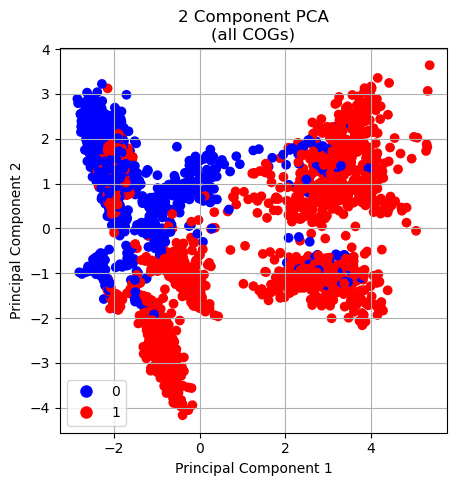

In [11]:
plt.figure(figsize=(5, 5))

colors = {0: 'blue', 1: 'red'}

plt.scatter(finalDf['PC 1'], finalDf['PC 2'], 
            c=finalDf['oxytolerance'].map(colors))

plt.title('2 Component PCA\n(all COGs)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

blue_patch = plt.Line2D([0], [0], marker='o', color='w', label='0', markerfacecolor='blue', markersize=10)
red_patch = plt.Line2D([0], [0], marker='o', color='w', label='1', markerfacecolor='red', markersize=10)
plt.legend(handles=[blue_patch, red_patch])

plt.grid()
plt.show()

**Colored by domain (bacteria vs archaea)**

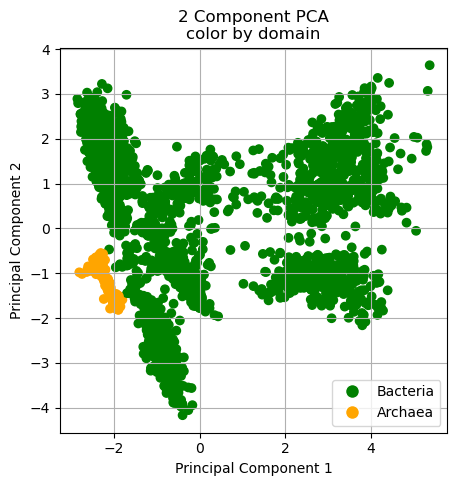

In [13]:
plt.figure(figsize=(5, 5))

colors = {'d__Bacteria': 'green', 'd__Archaea': 'orange'}

plt.scatter(finalDf['PC 1'], finalDf['PC 2'],
            c=pd.Series(d3['domain']).map(colors))

plt.title('2 Component PCA\ncolor by domain')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

blue_patch = plt.Line2D([0], [0], marker='o', color='w', label='Bacteria', markerfacecolor='green', markersize=10)
red_patch = plt.Line2D([0], [0], marker='o', color='w', label='Archaea', markerfacecolor='orange', markersize=10)
plt.legend(handles=[blue_patch, red_patch])

plt.grid()
plt.show();

**Colored by Phylum**

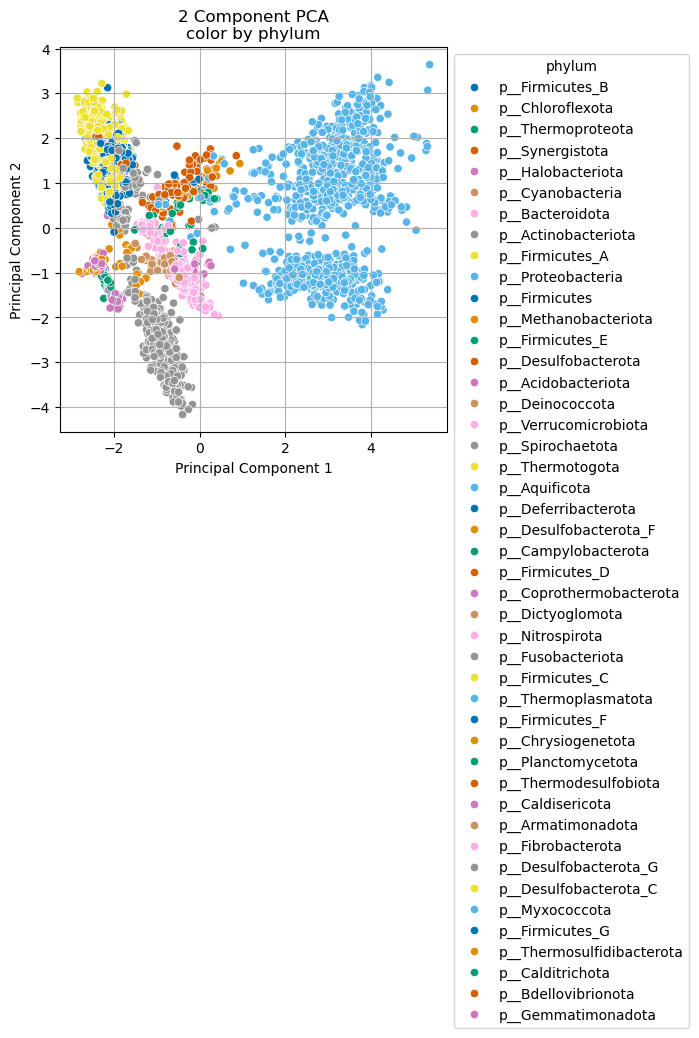

In [14]:
plt.figure(figsize=(5, 5))

ax = sns.scatterplot(x=finalDf['PC 1'],
                    y=finalDf['PC 2'],
                    hue=d3['phylum'], palette="colorblind")

plt.title('2 Component PCA\ncolor by phylum')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.grid()
plt.show();

## 2. tSNE projections

*All features*

In [15]:
def plot_tsne(data, n_iter=1000, 
              perplexity=40, color=None, if_move_legend=False, title=None):
    """
    Function for plotting t-SNE output
        :param data: objects x features table
        :param n_iter: number of gradient descent iterations,
            maybe useful to increase to get better results
        :param perplexity: 
        :param color: np.array[n_samples] with the variable
            we want to color our observations with
        :return tsne_emb: np.array[n_samples, 2] - t-SNE output
    """
    
    # Use PCA as initial approximation
    pca = PCA().fit(data)
    pca_embedding = pca.transform(data)
    
    # t-SNE
    tnse = TSNE(n_components=2, init=pca_embedding[:, :2], n_jobs=-1,
                n_iter=n_iter, perplexity=perplexity)
    tsne_embedding = tnse.fit_transform(pca_embedding)
    
    ax = sns.scatterplot(x=tsne_embedding[:, 0],
                    y=tsne_embedding[:, 1],
                    hue=color, palette="colorblind")
    if if_move_legend: 
        sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    plt.xlabel("$TSNE_1$", fontsize=18)
    plt.ylabel("$TSNE_2$", fontsize=18)
    plt.title(title)#'2 Component PCA\n(all COGs)')
    
    
    return tsne_embedding

In [16]:
X_scaled = MaxAbsScaler().fit_transform(X)

/Users/olgabagrova/olgab/bacterial_dating_aerobic_predictor/env/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


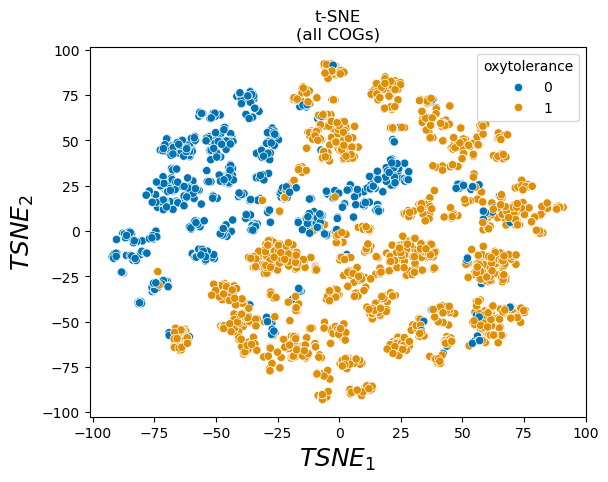

In [17]:
#color by y
tsne_res = plot_tsne(X_scaled, perplexity=10, color=y, title='t-SNE\n(all COGs)')

/Users/olgabagrova/olgab/bacterial_dating_aerobic_predictor/env/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


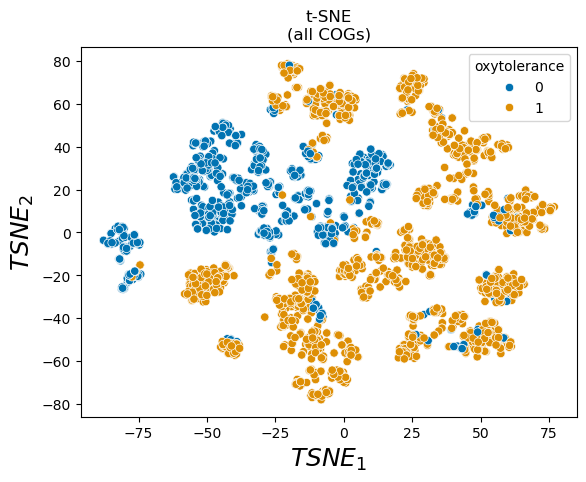

In [18]:
#color by y
tsne_res = plot_tsne(X_scaled, perplexity=20, color=y, title='t-SNE\n(all COGs)')

/Users/olgabagrova/olgab/bacterial_dating_aerobic_predictor/env/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


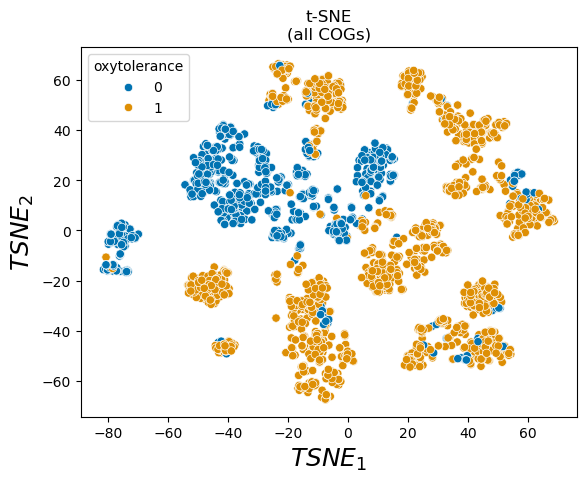

In [19]:
#color by y
tsne_res = plot_tsne(X_scaled, perplexity=30, color=y, title='t-SNE\n(all COGs)')

/Users/olgabagrova/olgab/bacterial_dating_aerobic_predictor/env/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


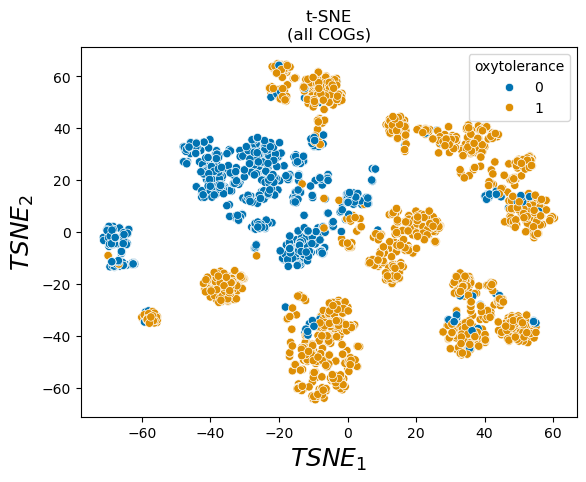

In [20]:
#color by y
tsne_res = plot_tsne(X_scaled, perplexity=40, color=y, title='t-SNE\n(all COGs)')

/Users/olgabagrova/olgab/bacterial_dating_aerobic_predictor/env/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


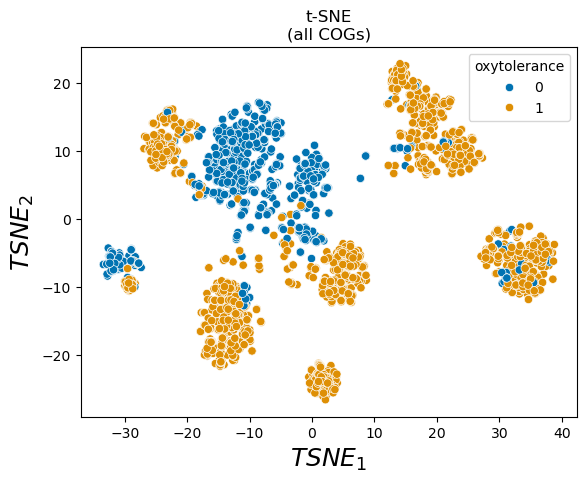

In [21]:
#color by y
tsne_res = plot_tsne(X_scaled, perplexity=200, color=y, title='t-SNE\n(all COGs)')

/Users/olgabagrova/olgab/bacterial_dating_aerobic_predictor/env/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


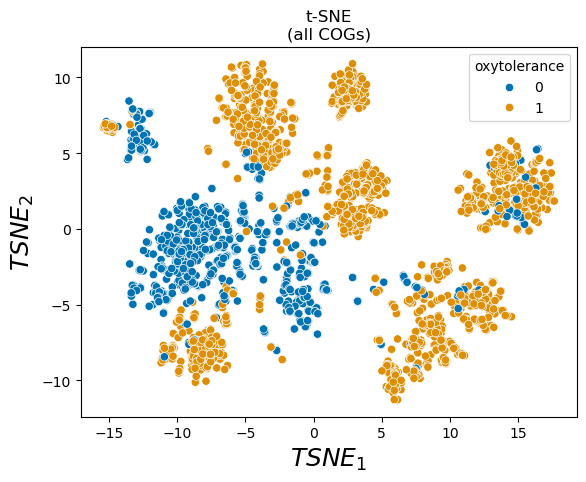

In [22]:
#color by y
tsne_res = plot_tsne(X_scaled, perplexity=500, color=y, title='t-SNE\n(all COGs)')

/Users/olgabagrova/olgab/bacterial_dating_aerobic_predictor/env/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


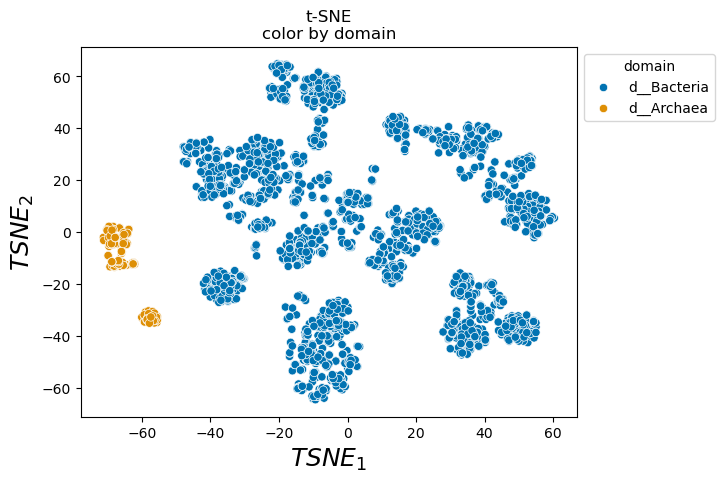

In [23]:
#color by domain
tsne_res = plot_tsne(X_scaled, color=d3['domain'], if_move_legend=True, title='t-SNE\ncolor by domain')

/Users/olgabagrova/olgab/bacterial_dating_aerobic_predictor/env/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


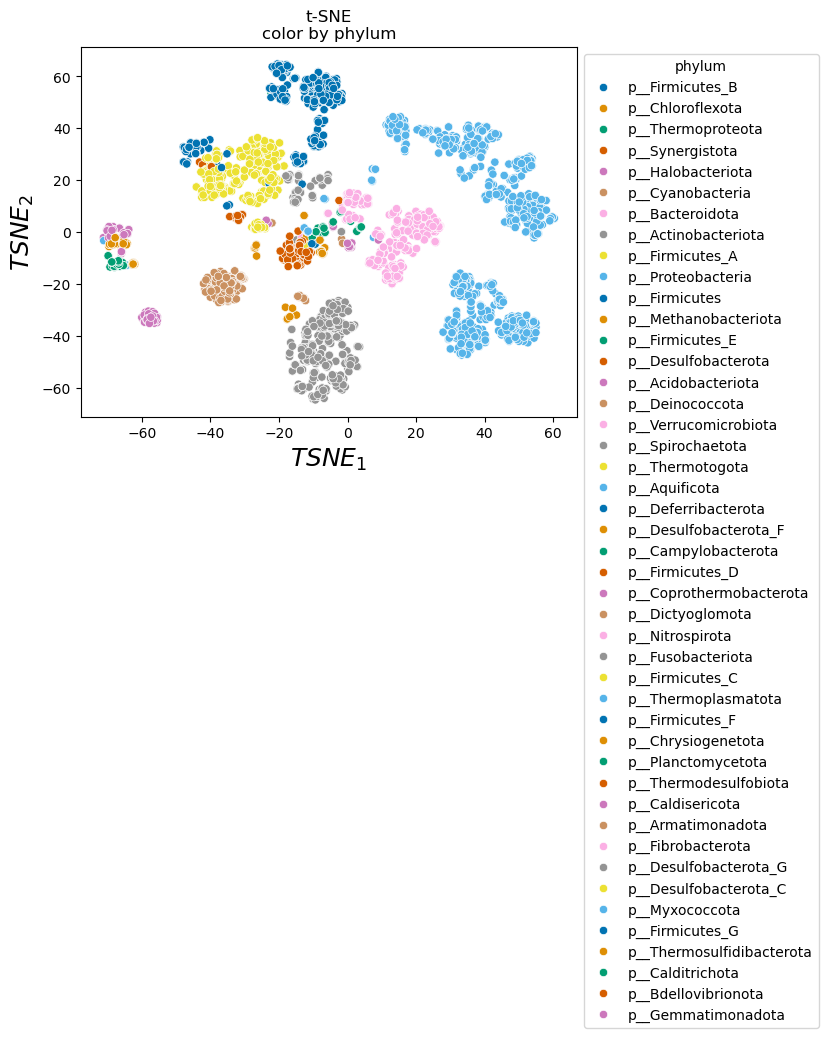

In [24]:
#color by phylum
tsne_res = plot_tsne(X_scaled, color=d3['phylum'], if_move_legend=True, title='t-SNE\ncolor by phylum')

In [25]:
import warnings
warnings.filterwarnings('ignore')